In [1]:
from keras import utils
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
os.environ['CUDA_VISIBLE_DEVICES']='1'
# dataset
# https://www.kaggle.com/c/facial-keypoints-detection

#定义网络结构
def CNN_model(size):
    input_data = Input(size)
    
    x = Conv2D(32, (3, 3), activation='relu')(input_data)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (2, 2), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (2, 2), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(1024,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024,activation='relu')(x)
    output = Dense(30)(x)
    return Model(inputs=input_data, outputs=output, name='Discriminator')

model=CNN_model((96, 96, 1))
optimizer = SGD(lr=0.03, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer=optimizer)
epoch_num = 1000
learning_rate = np.linspace(0.03, 0.01, epoch_num)
change_lr = LearningRateScheduler(lambda epoch: float(learning_rate[epoch]))
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')
check_point= ModelCheckpoint('CNN_model_final.h5', monitor='val_loss',verbose=0,save_best_only=True,save_weights_only=False, mode='auto', period=1)

/home/lhw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/lhw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
#读取数据
import pandas as pd
import numpy as np
label_path='../data/training.csv'
kp_df=pd.read_csv(label_path)
kp_df.head(10)

#去掉NAN的行
kp_df.dropna(axis=0, how='any', inplace=True)
print(kp_df.shape)
kp_df.head()

train_path='../data/dataset/train/'
data_list=list(map(lambda x:train_path+str(x)+'.jpg',kp_df.index))
print(data_list[0:5])
labels=kp_df.values
print(labels[0:3,:])

#shuffle
index=np.arange(len(data_list))
np.random.seed(2018)
np.random.shuffle(index)
data_list=np.array(data_list)
data_list=data_list[index]
labels=labels[index,:]
print('after shuffle:')
print(data_list[0:5])
print(labels[0:3,:])

#split train/val
train_list=data_list[0:int(len(data_list)*0.8)]
train_labels=labels[0:int(len(data_list)*0.8),:]
val_list=data_list[int(len(data_list)*0.8):]
val_labels=labels[int(len(data_list)*0.8):,:]
print('train_labels:',train_labels.shape)
print('val_labels:',val_labels.shape)

(2140, 31)
['../data/dataset/train/0.jpg', '../data/dataset/train/1.jpg', '../data/dataset/train/2.jpg', '../data/dataset/train/3.jpg', '../data/dataset/train/4.jpg']
[[66.0335639098 39.0022736842 30.2270075188 36.4216781955
  59.582075188000005 39.647422556399995 73.1303458647 39.9699969925
  36.3565714286 37.3894015038 23.4528721805 37.3894015038 56.9532631579
  29.0336481203 80.2271278195 32.2281383459 40.2276090226 29.0023218045
  16.3563789474 29.6474706767 44.4205714286 57.0668030075 61.1953082707
  79.9701654135 28.6144962406 77.38899248119999 43.3126015038
  72.9354586466 43.1307067669 84.4857744361
  '238 236 237 238 240 240 239 241 241 243 240 239 231 212 190 173 148 122 104 92 79 73 74 73 73 74 81 74 60 64 75 86 93 102 100 105 109 114 121 127 132 134 137 137 140 139 138 137 137 140 141 143 144 147 148 149 147 147 148 145 147 144 146 147 147 143 134 130 130 128 116 104 98 90 82 78 85 88 86 80 77 87 108 111 115 128 133 188 242 252 250 248 251 250 250 250 235 238 236 238 238 23

In [7]:
from skimage import io
#生成器generator
def generate_for_kp(file_list, label_list, batch_size):
    while True:
        count = 0
        x, y = [], []
        for i,path in enumerate(file_list):
            img=io.imread(path)
            img = np.array(img)
            x_temp=img/255.0
            y_temp=(label_list[i,:]-48.0)/48.0
            count += 1
            x.append(x_temp)
            y.append(y_temp)
            if count % batch_size == 0 and count != 0:
                x = np.array(x)
                x = x.reshape(batch_size, 96, 96, 1).astype("float32")
                y = np.array(y)
                yield x, y
                x, y = [], []
                
def generate_for_kp_test(file_list, batch_size):
    while True:
        count = 0
        x= []
        for path in file_list:
            img=io.imread(path)
            img = np.array(img)
            x_temp=img/255.0
            count += 1
            x.append(x_temp)
            if count % batch_size == 0 and count != 0:
                x = np.array(x)
                x = x.reshape(batch_size, 96, 96, 1).astype("float32")
                yield x
                x = []

In [8]:
model.fit_generator(generate_for_kp(train_list,train_labels,64),steps_per_epoch=int(len(train_list)/64)+1,\
                    epochs=epoch_num,verbose=1,validation_data=generate_for_kp(val_list,val_labels,64),\
                    validation_steps=int(len(val_list)/64)+1,\
                    callbacks=[change_lr,early_stop,check_point])

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/lhw/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/lhw/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lhw/anaconda3/lib/python3.6/site-packages/keras/utils/data_utils.py", line 568, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-7-52317e7e4f4a>", line 8, in generate_for_kp
    img=io.imread(path)
  File "/home/lhw/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py", line 61, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/home/lhw/anaconda3/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 211, in call_plugin
    return func(*args, **kwargs)
  File "/home/lhw/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/pil_plugin.py", line 35, in imread
    with open(fname, 'rb') as f:
FileNo

Epoch 1/1000


StopIteration: 

training results:


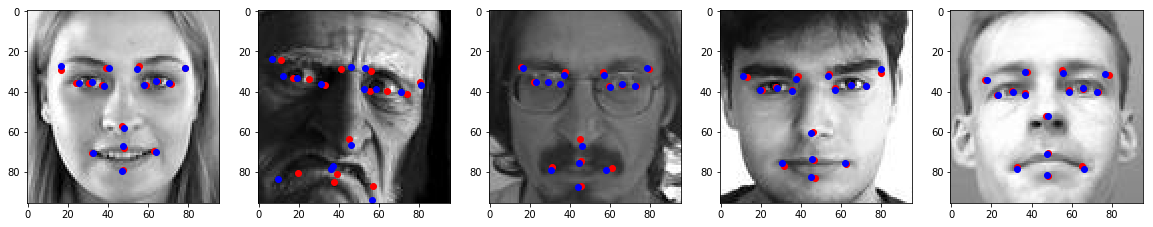

In [11]:
import matplotlib.pyplot as plt
from skimage import io
np.random.seed(2018)
#trainset predict step
model.load_weights('CNN_model_final.h5')
test_list=np.array(list(map(lambda x:'dataset/test/'+str(x),os.listdir('dataset/test/'))))
train_index=np.arange(len(train_list))
val_index=np.arange(len(val_list))
test_index=np.arange(len(test_list))
np.random.shuffle(train_index)
np.random.shuffle(val_index)
np.random.shuffle(test_index)
train_index=train_index[0:5]
val_index=val_index[0:5]
test_index=test_index[0:5]
train_predict=train_list[train_index]
val_predict=val_list[val_index]
test_predict=test_list[test_index]
train_label_predict=train_labels[train_index]
val_label_predict=val_labels[val_index]

train_img=[]
val_img=[]
test_img=[]
for t in train_predict:
    train_img.append(io.imread(t)/255.)
for t in val_predict:
    val_img.append(io.imread(t)/255.)
for t in test_predict:
    test_img.append(io.imread(t)/255.)

#draw train results
print('training results:')
plt.figure(figsize=(20,20)) 
for i,t in enumerate(train_img):
    prediction=model.predict(t.reshape(1, 96, 96, 1))[0]
    prediction=prediction*48.0+48.0
    x_list=prediction[np.arange(0,29,2)]
    y_list=prediction[np.arange(1,30,2)]
    x_list_real=train_label_predict[i][np.arange(0,29,2)]
    y_list_real=train_label_predict[i][np.arange(1,30,2)]
    
    plt.subplot(1,5,i+1)
    plt.imshow(t,cmap=plt.cm.gray)
    plt.scatter(x_list,y_list,c='r')
    plt.scatter(x_list_real,y_list_real,c='b')
plt.show()
    

validation results:


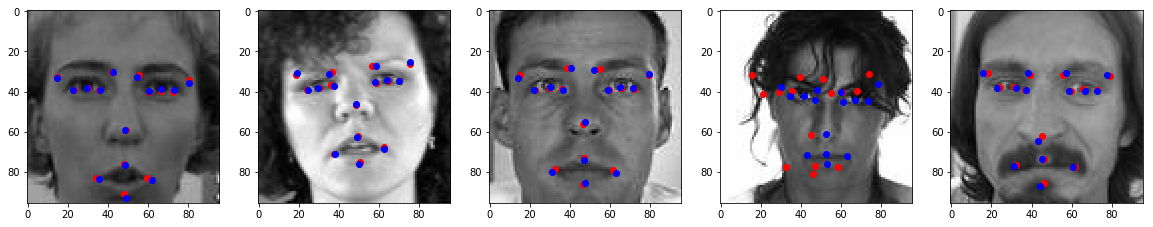

In [12]:
#draw val results
print('validation results:')
plt.figure(figsize=(20,20)) 
for i,t in enumerate(val_img):
    prediction=model.predict(t.reshape(1, 96, 96, 1))[0]
    prediction=prediction*48.0+48.0
    x_list=prediction[np.arange(0,29,2)]
    y_list=prediction[np.arange(1,30,2)]
    x_list_real=val_label_predict[i][np.arange(0,29,2)]
    y_list_real=val_label_predict[i][np.arange(1,30,2)]
    
    plt.subplot(1,5,i+1)
    plt.imshow(t,cmap=plt.cm.gray)
    plt.scatter(x_list,y_list,c='r')
    plt.scatter(x_list_real,y_list_real,c='b')
plt.show()    

test results:


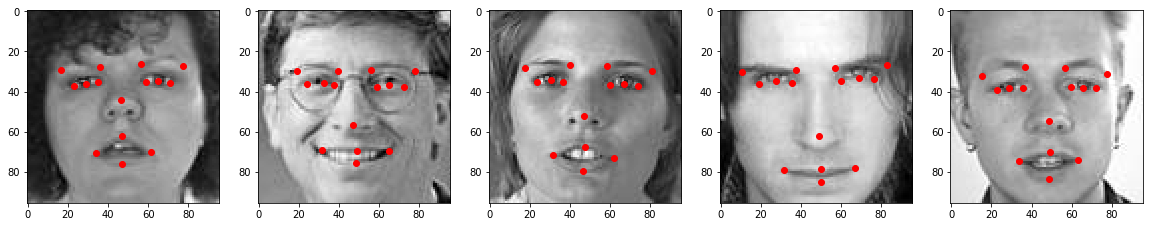

In [13]:
#draw test results
print('test results:')
plt.figure(figsize=(20,20)) 
for i,t in enumerate(test_img):
    prediction=model.predict(t.reshape(1, 96, 96, 1))[0]
    prediction=prediction*48.0+48.0
    x_list=prediction[np.arange(0,29,2)]
    y_list=prediction[np.arange(1,30,2)]
    
    plt.subplot(1,5,i+1)
    plt.imshow(t,cmap=plt.cm.gray)
    plt.scatter(x_list,y_list,c='r')
plt.show()    

In [18]:
#对test进行预测
import matplotlib.pyplot as plt
from skimage import io
np.random.seed(2018)
#trainset predict step
model.load_weights('CNN_model_final.h5')
test_list=np.arange(1,1784)
test_list=list(map(lambda x:'dataset/test/'+str(x)+'.jpg',test_list))
result=model.predict_generator(generate_for_kp_test(test_list,64),steps=int(len(test_list)/64)+1,verbose=1)
result=result*48+48
print(result.shape)

28/28 [==============================] - 5s 191ms/step
(1792, 30)
